<a href="https://colab.research.google.com/github/Bagito999/Deep-Learning/blob/main/IMDb_RNN_LSTM_GRU_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
num_words = 30000
maxlen = 400  # Bisa diubah ke 300~500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# Convert to tensor
x_train, y_train = torch.tensor(x_train), torch.tensor(y_train)
x_test, y_test = torch.tensor(x_test), torch.tensor(y_test)


In [ ]:
class IMDBDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_dataset = IMDBDataset(x_train, y_train)
test_dataset = IMDBDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


#Model Deep Learning RNN

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.dropout(self.relu(self.fc1(out)))
        out = torch.sigmoid(self.fc2(out))
        return out


In [ ]:
model = RNNModel(vocab_size=num_words, embed_dim=128, hidden_dim=128).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_acc_list, test_acc_list, train_loss_list, test_loss_list = [], [], [], []

for epoch in range(10):
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0.0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device).float()
        outputs = model(data).squeeze()
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (outputs >= 0.5).int()
        train_correct += (preds == labels.int()).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss / len(train_loader))

    # Evaluation
    model.eval()
    test_correct, test_total, test_loss = 0, 0, 0.0
    all_preds, all_labels, all_scores = [], [], []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device).float()
            outputs = model(data).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            probs = outputs.detach().cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            all_preds.extend(preds)
            all_scores.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(all_labels, all_preds)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss / len(test_loader))

    print(f"Epoch [{epoch+1}/10] "
          f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss_list[-1]:.4f} | "
          f"Test Acc: {test_acc:.4f}, Test Loss: {test_loss_list[-1]:.4f}")


Epoch [1/10] Train Acc: 0.5923, Train Loss: 0.6613 | Test Acc: 0.6416, Test Loss: 0.6287
Epoch [2/10] Train Acc: 0.7009, Train Loss: 0.5735 | Test Acc: 0.7062, Test Loss: 0.5632
Epoch [3/10] Train Acc: 0.7311, Train Loss: 0.5343 | Test Acc: 0.7352, Test Loss: 0.5450
Epoch [4/10] Train Acc: 0.7108, Train Loss: 0.5535 | Test Acc: 0.7084, Test Loss: 0.5613
Epoch [5/10] Train Acc: 0.7049, Train Loss: 0.5581 | Test Acc: 0.7184, Test Loss: 0.5566
Epoch [6/10] Train Acc: 0.6928, Train Loss: 0.5792 | Test Acc: 0.6027, Test Loss: 0.6511
Epoch [7/10] Train Acc: 0.7500, Train Loss: 0.5201 | Test Acc: 0.7110, Test Loss: 0.5553
Epoch [8/10] Train Acc: 0.7620, Train Loss: 0.4995 | Test Acc: 0.6948, Test Loss: 0.5977
Epoch [9/10] Train Acc: 0.7936, Train Loss: 0.4641 | Test Acc: 0.5744, Test Loss: 0.8466
Epoch [10/10] Train Acc: 0.7587, Train Loss: 0.4995 | Test Acc: 0.7054, Test Loss: 0.6037


Final Training Accuracy: 0.7587
Final Testing Accuracy: 0.7054
Precision: 0.7090
Recall: 0.6966
F1 Squared: 0.4938
AUC: 0.7761


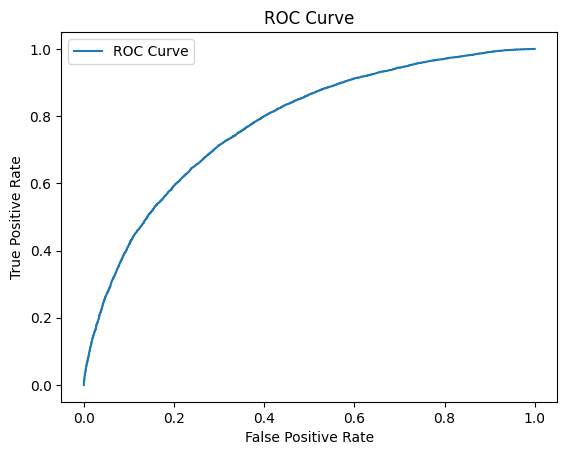

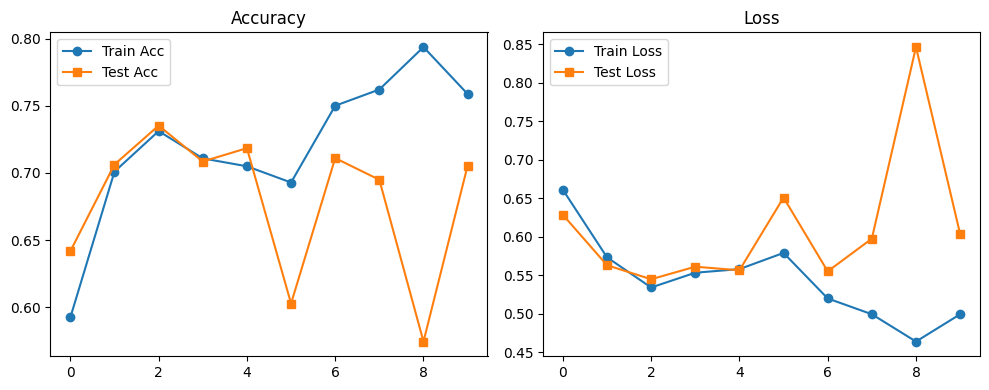

In [ ]:
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1_sq = f1_score(all_labels, all_preds)**2
auc = roc_auc_score(all_labels, all_scores)

print(f"Final Training Accuracy: {train_acc_list[-1]:.4f}")
print(f"Final Testing Accuracy: {test_acc_list[-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Squared: {f1_sq:.4f}")
print(f"AUC: {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_scores)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Accuracy & Loss Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label="Train Acc", marker='o')
plt.plot(test_acc_list, label="Test Acc", marker='s')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label="Train Loss", marker='o')
plt.plot(test_loss_list, label="Test Loss", marker='s')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()


#Model Deep Learning LSTM

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Ambil output terakhir
        out = self.dropout(self.relu(self.fc1(out)))
        out = torch.sigmoid(self.fc2(out))
        return out


In [ ]:
model = LSTMModel(vocab_size=num_words, embed_dim=128, hidden_dim=128).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_acc_list, test_acc_list, train_loss_list, test_loss_list = [], [], [], []


In [ ]:
for epoch in range(10):
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0.0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device).float()
        outputs = model(data).squeeze()
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (outputs >= 0.5).int()
        train_correct += (preds == labels.int()).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss / len(train_loader))

    # Evaluation
    model.eval()
    test_correct, test_total, test_loss = 0, 0, 0.0
    all_preds, all_labels, all_scores = [], [], []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device).float()
            outputs = model(data).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            probs = outputs.detach().cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            all_preds.extend(preds)
            all_scores.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(all_labels, all_preds)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss / len(test_loader))

    print(f"Epoch [{epoch+1}/10] "
          f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss_list[-1]:.4f} | "
          f"Test Acc: {test_acc:.4f}, Test Loss: {test_loss_list[-1]:.4f}")



Epoch [1/10] Train Acc: 0.6386, Train Loss: 0.6160 | Test Acc: 0.7427, Test Loss: 0.5114
Epoch [2/10] Train Acc: 0.7594, Train Loss: 0.4948 | Test Acc: 0.6868, Test Loss: 0.5814
Epoch [3/10] Train Acc: 0.7504, Train Loss: 0.5006 | Test Acc: 0.8216, Test Loss: 0.4083
Epoch [4/10] Train Acc: 0.8478, Train Loss: 0.3504 | Test Acc: 0.8026, Test Loss: 0.4556
Epoch [5/10] Train Acc: 0.8922, Train Loss: 0.2676 | Test Acc: 0.8568, Test Loss: 0.3359
Epoch [6/10] Train Acc: 0.9216, Train Loss: 0.2036 | Test Acc: 0.8724, Test Loss: 0.3425
Epoch [7/10] Train Acc: 0.9420, Train Loss: 0.1560 | Test Acc: 0.8782, Test Loss: 0.3444
Epoch [8/10] Train Acc: 0.9595, Train Loss: 0.1164 | Test Acc: 0.8747, Test Loss: 0.3554
Epoch [9/10] Train Acc: 0.9724, Train Loss: 0.0827 | Test Acc: 0.8730, Test Loss: 0.4403
Epoch [10/10] Train Acc: 0.9792, Train Loss: 0.0657 | Test Acc: 0.8749, Test Loss: 0.4479


Final Training Accuracy: 0.9792
Final Testing Accuracy: 0.8749
Precision: 0.8767
Recall: 0.8724
F1 Squared: 0.7649
AUC: 0.9437


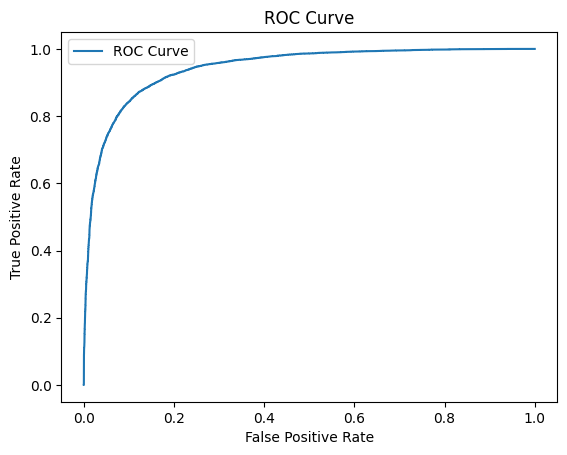

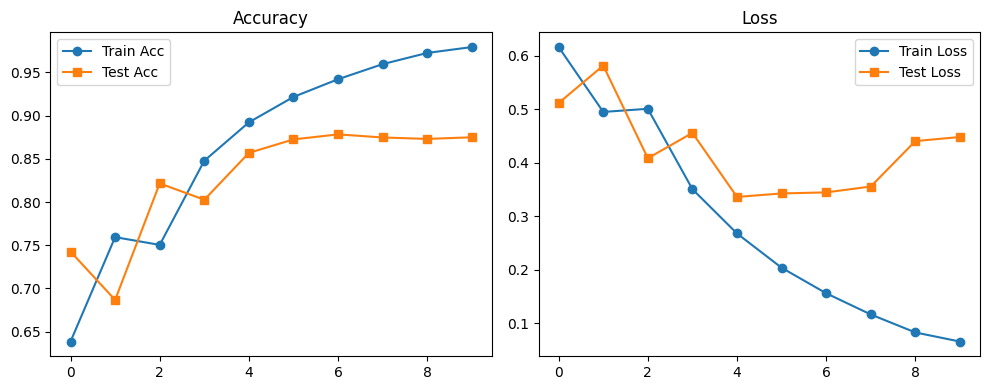

In [ ]:
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1_sq = f1_score(all_labels, all_preds)**2
auc = roc_auc_score(all_labels, all_scores)

print(f"Final Training Accuracy: {train_acc_list[-1]:.4f}")
print(f"Final Testing Accuracy: {test_acc_list[-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Squared: {f1_sq:.4f}")
print(f"AUC: {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_scores)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Accuracy & Loss Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label="Train Acc", marker='o')
plt.plot(test_acc_list, label="Test Acc", marker='s')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label="Train Loss", marker='o')
plt.plot(test_loss_list, label="Test Loss", marker='s')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()


#Model Deep Learning GRU

In [ ]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.3)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.dropout(self.relu(self.fc1(out)))
        out = torch.sigmoid(self.fc2(out))
        return out


In [ ]:
model = GRUModel(vocab_size=num_words, embed_dim=128, hidden_dim=128).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_acc_list, test_acc_list, train_loss_list, test_loss_list = [], [], [], []


In [ ]:
for epoch in range(10):
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0.0

    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device).float()
        outputs = model(data).squeeze()
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = (outputs >= 0.5).int()
        train_correct += (preds == labels.int()).sum().item()
        train_total += labels.size(0)

    train_acc = train_correct / train_total
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss / len(train_loader))

    # Evaluation
    model.eval()
    test_correct, test_total, test_loss = 0, 0, 0.0
    all_preds, all_labels, all_scores = [], [], []

    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device).float()
            outputs = model(data).squeeze()
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            probs = outputs.detach().cpu().numpy()
            preds = (probs >= 0.5).astype(int)
            all_preds.extend(preds)
            all_scores.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(all_labels, all_preds)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss / len(test_loader))

    print(f"Epoch [{epoch+1}/10] "
          f"Train Acc: {train_acc:.4f}, Train Loss: {train_loss_list[-1]:.4f} | "
          f"Test Acc: {test_acc:.4f}, Test Loss: {test_loss_list[-1]:.4f}")


Epoch [1/10] Train Acc: 0.6770, Train Loss: 0.5853 | Test Acc: 0.7864, Test Loss: 0.4584
Epoch [2/10] Train Acc: 0.8196, Train Loss: 0.4066 | Test Acc: 0.8477, Test Loss: 0.3618
Epoch [3/10] Train Acc: 0.8972, Train Loss: 0.2544 | Test Acc: 0.8752, Test Loss: 0.2950
Epoch [4/10] Train Acc: 0.9338, Train Loss: 0.1768 | Test Acc: 0.8675, Test Loss: 0.3259
Epoch [5/10] Train Acc: 0.9587, Train Loss: 0.1160 | Test Acc: 0.8732, Test Loss: 0.3758
Epoch [6/10] Train Acc: 0.9749, Train Loss: 0.0755 | Test Acc: 0.8609, Test Loss: 0.4353
Epoch [7/10] Train Acc: 0.9855, Train Loss: 0.0473 | Test Acc: 0.8681, Test Loss: 0.4972
Epoch [8/10] Train Acc: 0.9880, Train Loss: 0.0386 | Test Acc: 0.8718, Test Loss: 0.5300
Epoch [9/10] Train Acc: 0.9914, Train Loss: 0.0275 | Test Acc: 0.8662, Test Loss: 0.6066
Epoch [10/10] Train Acc: 0.9927, Train Loss: 0.0222 | Test Acc: 0.8714, Test Loss: 0.5846


Final Training Accuracy: 0.9927
Final Testing Accuracy: 0.8714
Precision: 0.8602
Recall: 0.8870
F1 Squared: 0.7629
AUC: 0.9424


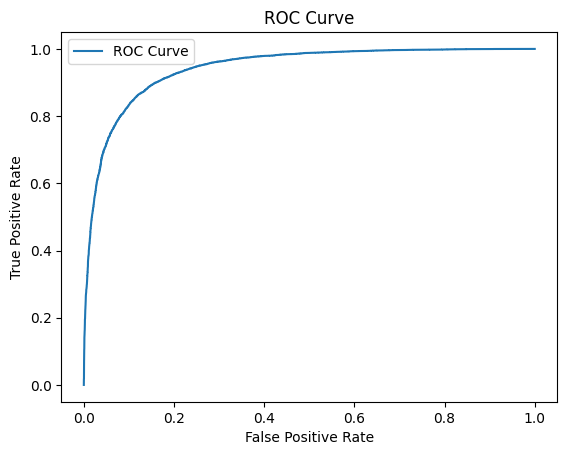

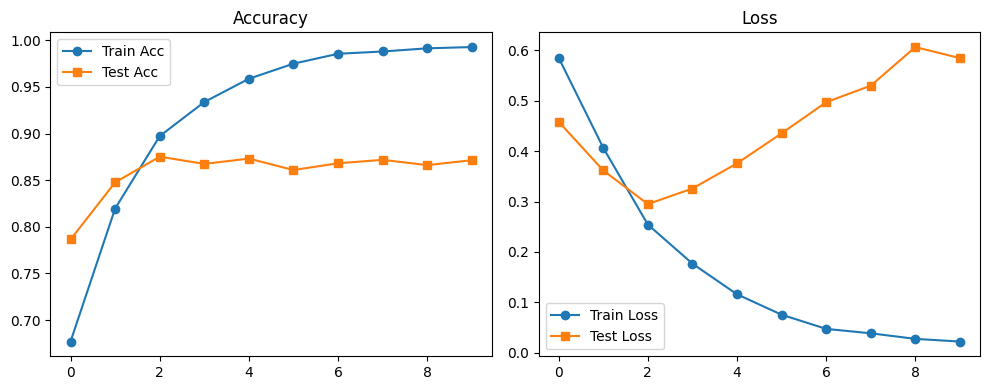

In [ ]:
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1_sq = f1_score(all_labels, all_preds)**2
auc = roc_auc_score(all_labels, all_scores)

print(f"Final Training Accuracy: {train_acc_list[-1]:.4f}")
print(f"Final Testing Accuracy: {test_acc_list[-1]:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Squared: {f1_sq:.4f}")
print(f"AUC: {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_scores)
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Accuracy & Loss Plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label="Train Acc", marker='o')
plt.plot(test_acc_list, label="Test Acc", marker='s')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label="Train Loss", marker='o')
plt.plot(test_loss_list, label="Test Loss", marker='s')
plt.title("Loss")
plt.legend()
plt.tight_layout()
plt.show()


# 📘 Penjelasan Persamaan Matematika dalam Deep Learning

---

## 🔁 1. Recurrent Neural Network (RNN)

Model RNN mempertimbangkan urutan dengan memori internal:

\[
$h_t = \tanh(W_h h_{t-1} + W_x x_t + b)$
\]

- \($ h_t $\): Hidden state saat waktu \($ t $\)
- \($ x_t $\): Input saat waktu \($ t $\)
- \($ W_h, W_x $\): Bobot hidden dan input
- \($ b $\): Bias

---

## 🔒 2. Long Short-Term Memory (LSTM)

LSTM memiliki mekanisme gate untuk menangani long-term dependency:

\[
\begin{aligned}
f_t &= \sigma(W_f [h_{t-1}, x_t] + b_f) \quad \text{(forget gate)} \\
i_t &= \sigma(W_i [h_{t-1}, x_t] + b_i) \quad \text{(input gate)} \\
\tilde{C}_t &= \tanh(W_C [h_{t-1}, x_t] + b_C) \quad \text{(candidate state)} \\
C_t &= f_t * C_{t-1} + i_t * \tilde{C}_t \quad \text{(cell state)} \\
o_t &= \sigma(W_o [h_{t-1}, x_t] + b_o) \quad \text{(output gate)} \\
h_t &= o_t * \tanh(C_t) \quad \text{(hidden state)}
\end{aligned}
\]

---

## 🔁 3. Gated Recurrent Unit (GRU)

GRU adalah versi lebih sederhana dari LSTM:

\[
\begin{aligned}
z_t &= \sigma(W_z [h_{t-1}, x_t]) \quad \text{(update gate)} \\
r_t &= \sigma(W_r [h_{t-1}, x_t]) \quad \text{(reset gate)} \\
\tilde{h}_t &= \tanh(W [r_t * h_{t-1}, x_t]) \quad \text{(candidate state)} \\
h_t &= (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t \quad \text{(new state)}
\end{aligned}
\]

---

## 📉 4. Binary Cross-Entropy Loss

Untuk klasifikasi biner, fungsi loss adalah:

\[
\$mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \left[y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right]
$\]

- \($ y_i $\): Label sebenarnya (0 atau 1)
- \($ \hat{y}_i $\): Prediksi model

---

## 🧮 5. Evaluasi Model

**Akurasi:**

\[
$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$
\]

Keterangan:
- **TP** = True Positive
- **TN** = True Negative
- **FP** = False Positive
- **FN** = False Negative

**Presisi:**

\[$
\text{Precision} = \frac{TP}{TP + FP}
$\]

**Recall:**

\[$
\text{Recall} = \frac{TP}{TP + FN}
$\]

**F1 Score:**

\[$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$\]

**F1 Squared:**

\[$
F1^2 = (F1)^2
$\]

**AUC (Area Under Curve):** Luas di bawah kurva ROC yang menggambarkan trade-off antara TPR dan FPR.

**ROC Curve:** Grafik yang menunjukkan hubungan antara TPR (True Positive Rate) dan FPR (False Positive Rate).

---

